Link to dataset: [Here](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper as hlp
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

## Fetch dataset and create in & out dataframes

In [10]:
incomes_endpoint = 'https://data.austintexas.gov/resource/wter-evkm.json'
outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

import requests
params = {'$limit': 10000000} # If not specified it only returns 1000 records
r = requests.get(incomes_endpoint, params)
in_df = pd.DataFrame(r.json())
r = requests.get(outcomes_endpoint, params)
out_df = pd.DataFrame(r.json())

in_df['income_time'] = pd.to_datetime(in_df['datetime'])
out_df['outcome_time'] = pd.to_datetime(out_df['datetime'])
out_df['date_of_birth'] = pd.to_datetime(out_df['date_of_birth'])

in_df.drop(['datetime','datetime2'], axis=1, inplace=True)
out_df.drop(['monthyear', 'datetime'], axis=1, inplace=True)

print('Incomes shape',in_df.shape)
print('Outcomes shape',out_df.shape)


Incomes shape (122893, 11)
Outcomes shape (122839, 11)


In [11]:
in_df.head(5)

,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time
0,A827347,2005 Connestoga Trl in Austin (TX),Abandoned,Normal,Cat,Intact Male,6 months,Domestic Shorthair,Cream Tabby,NaN,2020-12-18 17:26:00
1,A827345,2005 Connestoga Trl in Austin (TX),Abandoned,Normal,Cat,Intact Male,6 months,Domestic Shorthair,Cream Tabby,NaN,2020-12-18 17:26:00
2,A827302,Brodie Ln And Fm 1626 in Travis (TX),Stray,Normal,Dog,Intact Female,2 years,Boxer/Labrador Retriever,Brown/White,NaN,2020-12-18 17:24:00
3,A827344,1212 Westheimer in Austin (TX),Stray,Injured,Cat,Intact Male,2 years,Domestic Shorthair,Brown Tabby/White,NaN,2020-12-18 17:15:00
4,A827343,Austin (TX),Owner Surrender,Normal,Dog,Intact Male,9 months,Catahoula Mix,Brown Merle/White,Sushi,2020-12-18 16:56:00


In [12]:
out_df.head(5)

,animal_id,name,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype,outcome_time
0,A821019,Spot,2017-04-03,Adoption,Dog,Neutered Male,3 years,Pit Bull,White/Black,NaN,2020-12-08 12:37:00
1,A824438,*Rose,2011-11-27,Adoption,Dog,Spayed Female,9 years,German Shepherd,Tan/Black,NaN,2020-12-08 12:27:00
2,A825587,*Ludwig,2011-11-06,Adoption,Cat,Neutered Male,9 years,Domestic Medium Hair,Cream Tabby,Foster,2020-12-08 12:22:00
3,A819626,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,White/Black,Foster,2020-12-08 11:53:00
4,A819624,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,Black,Foster,2020-12-08 11:52:00


## Create unique id to merge in & out datasets

In [13]:
in_df = hlp.create_unique_id(in_df, 'income')
out_df = hlp.create_unique_id(out_df, 'outcome')

## Check columns in common

In [14]:
print('Columns of the income ->',in_df.columns)
print('Columns of the outcome ->',out_df.columns)
set(in_df.columns).intersection(out_df.columns)

Columns of the income -> Index(['index', 'animal_id', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake', 'age_upon_intake',
       'breed', 'color', 'name', 'income_time', 'income_number',
       'animal_id_new'],
      dtype='object')
Columns of the outcome -> Index(['index', 'animal_id', 'name', 'date_of_birth', 'outcome_type',
       'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color',
       'outcome_subtype', 'outcome_time', 'outcome_number', 'animal_id_new'],
      dtype='object')


{'animal_id',
 'animal_id_new',
 'animal_type',
 'breed',
 'color',
 'index',
 'name'}

## Remove columns to avoid duplicates in merge

In [15]:
in_df.drop(['index'], axis=1, inplace=True)
out_df.drop(['index', 'animal_type', 'breed', 'color','name', 'animal_id'], axis=1, inplace=True)

#### Merge

In [16]:
in_df.set_index('animal_id_new', inplace=True)
out_df.set_index('animal_id_new', inplace=True)

in_out_df = pd.merge(out_df, in_df, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

In [18]:
print(in_out_df.columns)
print('Income shape', in_df.shape)
print('Outcome shape', out_df.shape)
print('In/out shape', in_out_df.shape)
in_out_df.head()
# TODO: see why the diference in row numbers (animals with income but not yet an outcome?) 

Index(['date_of_birth', 'outcome_type', 'sex_upon_outcome', 'age_upon_outcome',
       'outcome_subtype', 'outcome_time', 'outcome_number', 'animal_id',
       'found_location', 'intake_type', 'intake_condition', 'animal_type',
       'sex_upon_intake', 'age_upon_intake', 'breed', 'color', 'name',
       'income_time', 'income_number'],
      dtype='object')
Income shape (122893, 12)
Outcome shape (122839, 7)
In/out shape (121834, 19)


,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,outcome_subtype,outcome_time,outcome_number,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time,income_number
animal_id_new,,,,,,,,,,,,,,,,,,,
A006100_1,2007-07-09,Return to Owner,Neutered Male,10 years,NaN,2017-12-07 00:00:00,1.0,A006100,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,Scamp,2017-12-07 14:07:00,1.0
A006100_2,2007-07-09,Return to Owner,Neutered Male,7 years,NaN,2014-12-20 16:35:00,2.0,A006100,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-12-19 10:21:00,2.0
A006100_3,2007-07-09,Return to Owner,Neutered Male,6 years,NaN,2014-03-08 17:10:00,3.0,A006100,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-03-07 14:26:00,3.0
A047759_1,2004-04-02,Transfer,Neutered Male,10 years,Partner,2014-04-07 15:12:00,1.0,A047759,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10 years,Dachshund,Tricolor,Oreo,2014-04-02 15:55:00,1.0
A134067_1,1997-10-16,Return to Owner,Neutered Male,16 years,NaN,2013-11-16 11:54:00,1.0,A134067,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,Bandit,2013-11-16 09:02:00,1.0


## Create column time in shelter using outcome and income times

In [19]:
in_out_df['time_in_shelter'] = in_out_df['outcome_time'] - in_out_df['income_time']

In [20]:
in_out_df['time_in_shelter'].describe()

count                     121834
mean     17 days 09:27:42.166062
std      50 days 06:58:25.757474
min         -2411 days +06:11:00
25%              1 days 06:08:00
50%              5 days 02:02:00
75%             15 days 00:12:00
max           1521 days 23:31:00
Name: time_in_shelter, dtype: object

### Check why the negative value in min

In [21]:
in_later = in_out_df[['income_time', 'outcome_time']][in_out_df['income_time'] > in_out_df['outcome_time']]

print(len(in_later))
in_later.head()

760


,income_time,outcome_time
animal_id_new,,
A006100_1,2017-12-07 14:07:00,2017-12-07
A531969_1,2015-11-13 12:18:00,2015-11-13
A533243_2,2016-12-20 16:50:00,2016-12-20
A554047_2,2016-05-26 16:33:00,2016-05-26
A554047_3,2016-05-14 11:26:00,2016-05-14


### Fix time (also possible to delete those rows)

In [22]:
in_out_df['income_time'], in_out_df['outcome_time'] = np.where(in_out_df['income_time'] > in_out_df['outcome_time'], [in_out_df['outcome_time'], in_out_df['income_time']],[in_out_df['income_time'], in_out_df['outcome_time']])

In [23]:
in_out_df['time_in_shelter'] = pd.to_datetime(in_out_df['outcome_time']) - pd.to_datetime(in_out_df['income_time'])
in_out_df['time_in_shelter'].describe()

count                     121834
mean     18 days 15:13:22.424774
std      49 days 20:15:56.418831
min              0 days 00:00:00
25%              1 days 06:32:00
50%              5 days 02:16:00
75%             15 days 01:17:00
max           2410 days 17:49:00
Name: time_in_shelter, dtype: object

# Analysis of the data

In [24]:
sns.set(style="white", context="talk", font_scale=1.2)

In [25]:
in_out_df['animal_type'].value_counts()

Dog          69051
Cat          45693
Other         6498
Bird           573
Livestock       19
Name: animal_type, dtype: int64

### Remove Livestock type animals

In [26]:
in_out_df = in_out_df.loc[in_out_df['animal_type'] != 'Livestock']

### Top 10 intake to outcome cases

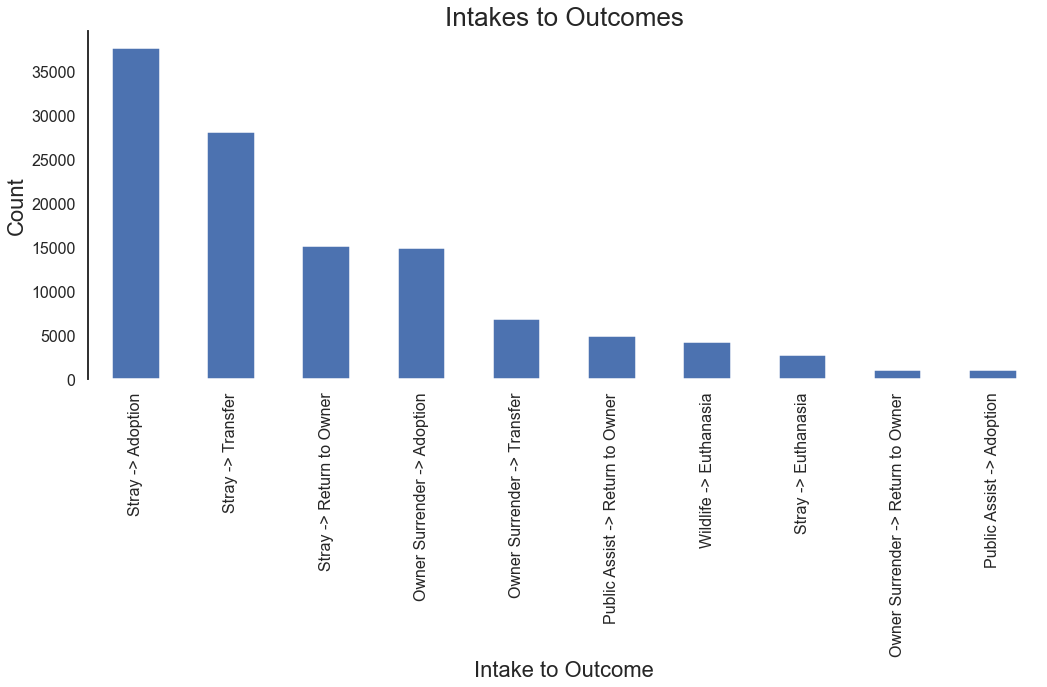

In [27]:
in_out_df['Intake_Outcome'] = in_out_df['intake_type'] + ' -> ' + in_out_df['outcome_type']

intake_outcomes = in_out_df['Intake_Outcome'].value_counts()[0:10].plot(kind='bar', 
                                                                     fontsize=16, 
                                                                     figsize=(15, 10))
intake_outcomes.set_ylabel('Count', fontsize=22)
intake_outcomes.set_xlabel('Intake to Outcome', fontsize=22)
intake_outcomes.set_title('Intakes to Outcomes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

### This 10 groups describe the %95 of the dataset

In [28]:
for i in range(1, 10):
    print(in_out_df['Intake_Outcome'].value_counts()[0:i].sum() / in_out_df['Intake_Outcome'].value_counts().sum())

0.30882521960430176
0.5397175929726623
0.6644035793448814
0.7872177982103276
0.8435432230522946
0.8841556522453
0.9189475412527707
0.9411953041622199
0.9499958952466957


##  Intakes and outcome results by the mean number of days in the shelter.

In [29]:
in_out_df['time_in_shelter'] = pd.to_timedelta(in_out_df['time_in_shelter'])
in_out_df['time_in_shelter_days'] = in_out_df['time_in_shelter'].dt.total_seconds() / (24 * 60 * 60)

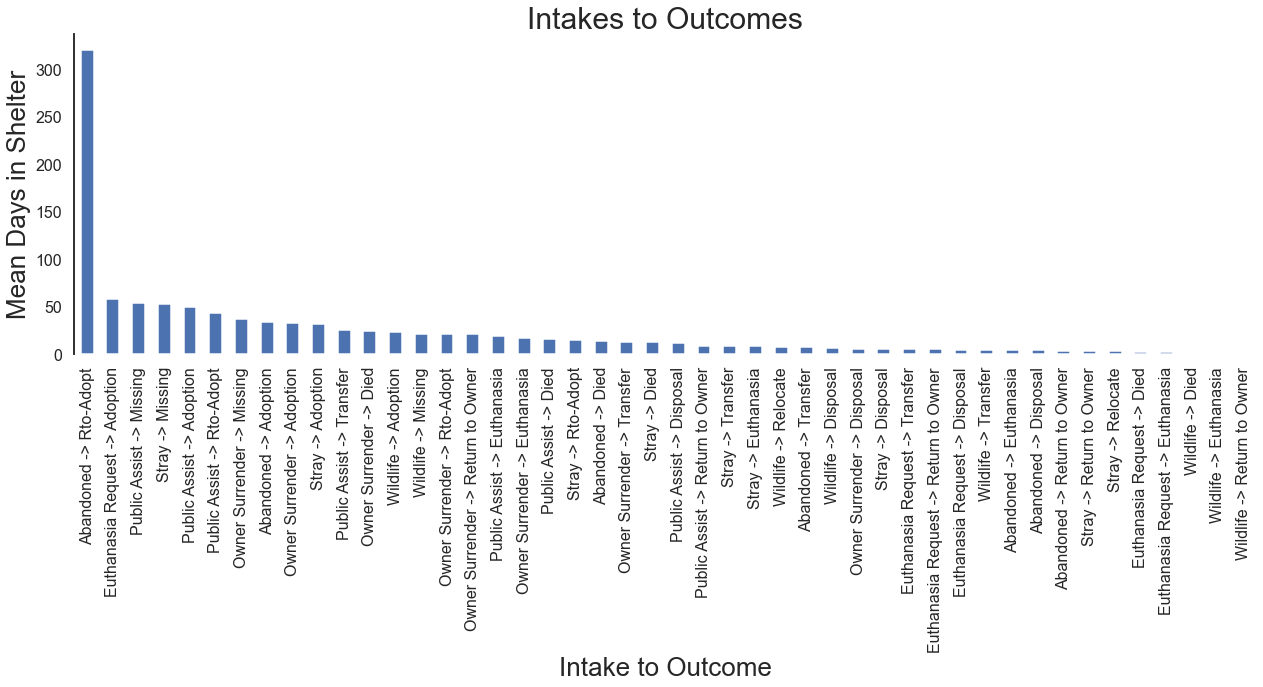

In [30]:
intake_outcome_days = in_out_df.groupby('Intake_Outcome')['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                        fontsize=16, 
                                                                                                                        figsize=(18, 10))

intake_outcome_days.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_outcome_days.set_xlabel('Intake to Outcome', fontsize=26)
intake_outcome_days.set_title('Intakes to Outcomes', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)